<a href="https://colab.research.google.com/github/amoulang/handson-ml2/blob/master/kmong_1623423998204_km_code_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import svm, metrics
from scipy.signal import savgol_filter
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
plt.rcParams['font.family'] = 'AppleGothic'
warnings.filterwarnings(action='ignore')

# 1. 데이터 전처리

### 결측값 처리

In [ ]:
# 데이터 불러오기
df = pd.read_excel('km_electric_data.xlsx')
# 데이터 결측치 0으로 채우기
df = df.fillna(0)
# 데이터 이상치 0으로 변환
df['부하전류'] = df['부하전류'].replace(['편단개방'], '0')
df['A-B'] = df['A-B'].replace(['무', '무 ','-'], '0')
df['B-C'] = df['B-C'].replace(['접', '접 ','-', '전', '양 단 비 접 지', ' 접 '], '0')
df['C-A'] = df['C-A'].replace(['지', '-', ' 지'], '0')
df['온도_B'] = df['온도_B'].replace(['28..4'], '28.4')
# 계획 변전소 제외 처리
lst_remove_place = '보광S/S|현저S/S|수유S/S'
df = df[~df['접속번호'].str.contains(lst_remove_place)]

In [ ]:
num_cols = ['허용전류', '부하전류', '부하율', 'A-B', 'B-C',
       'C-A', '시스전류_평균', '손실율_AB', '손실율_BC', '손실율_CA', '손실율_평균', '온도_A', '온도_B',
       '온도_C', '온도_평균', '대기온도', '상간온도', '대한', 'LS ', '일진', 'OF', 'XLPE',
       '굵기_1200', '굵기_2000', '굵기_2500', '설치년도', '사용년도', '접속함_경간', '수평', '수직',
       '삼각', '배열_가나형', '관로', '전력구', '혼합']
df[num_cols] = df[num_cols].astype(float)

### 데이터 보정
    선로별로 수치형 데이터들의 이상치들을 보정할 수 있는 smoothing 기법을 적용

In [ ]:
for lane in df['선로명'].unique():
    for col in num_cols:
        df_outlier = df.loc[df['선로명'] == lane, col]
        df.loc[df['선로명'] == lane, col] = savgol_filter(df_outlier, 5, 3)

### 데이터 재배열

In [ ]:
# 데이터 재배열 : 노선 별 일별 데이터로 취합(취합 시 평균으로 사용함, 예를 들어, 광장-뚝도 선로의 19년 1월 1일 허용전류 데이터가 여러개 있을 경우, 1월 1일 평균 허용전류로 변환)
# 평균이 아닌 다른 값으로 변경할 경우, 말씀주세요
# 하지만, 여러개의 컬럼으로 사용하는 것은 어려울 것 같습니다(예를 들어, 1월1일 첫번째 허용전류 컬럼, 1월1일 두번째 허용전류 컬럼 등...)
df = df.groupby(['선로명','측정일'])[num_cols].agg('mean').reset_index()

In [ ]:
# 학습과 검증 기간 분리를 위한 설정
df['yymm'] = df['측정일'].astype(str).apply(lambda x: x[:4])
train_range = ['1903', '1905', '1906', '1909', 
               '1910', '1912', '2003', '2005','2006', '2009']

# 2. 탐색적 분석

### 패턴 분석

광장-뚝도#1 T/L


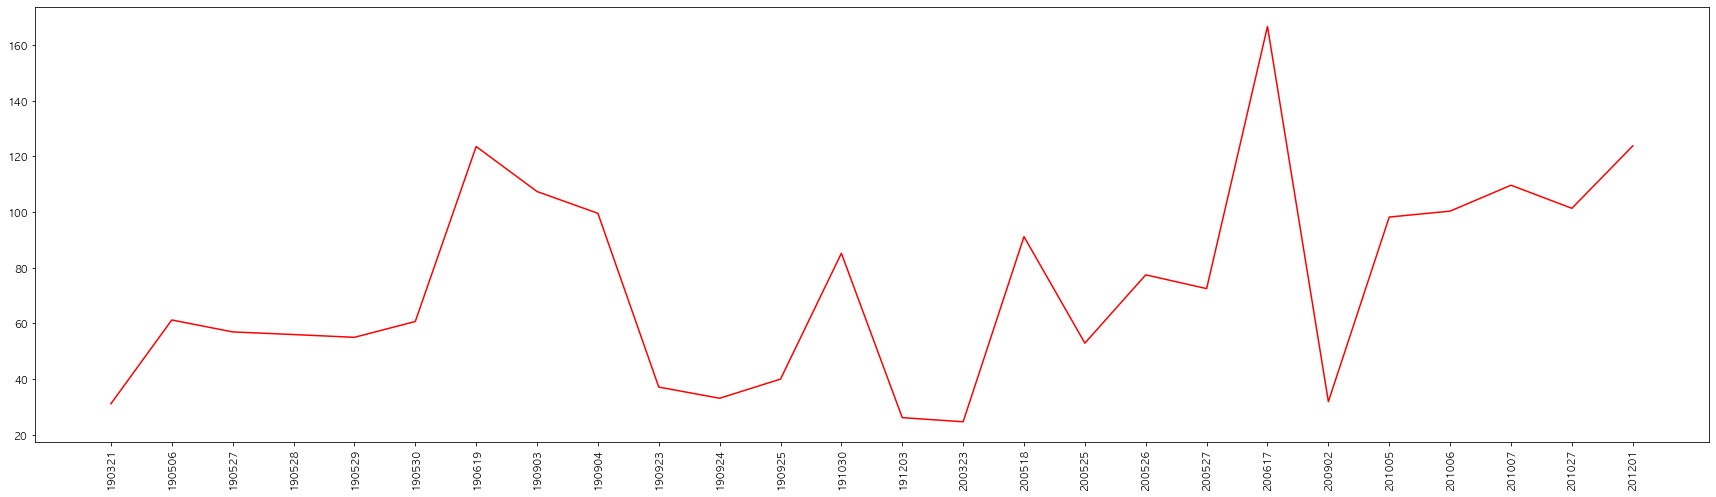

광장-뚝도#2 T/L


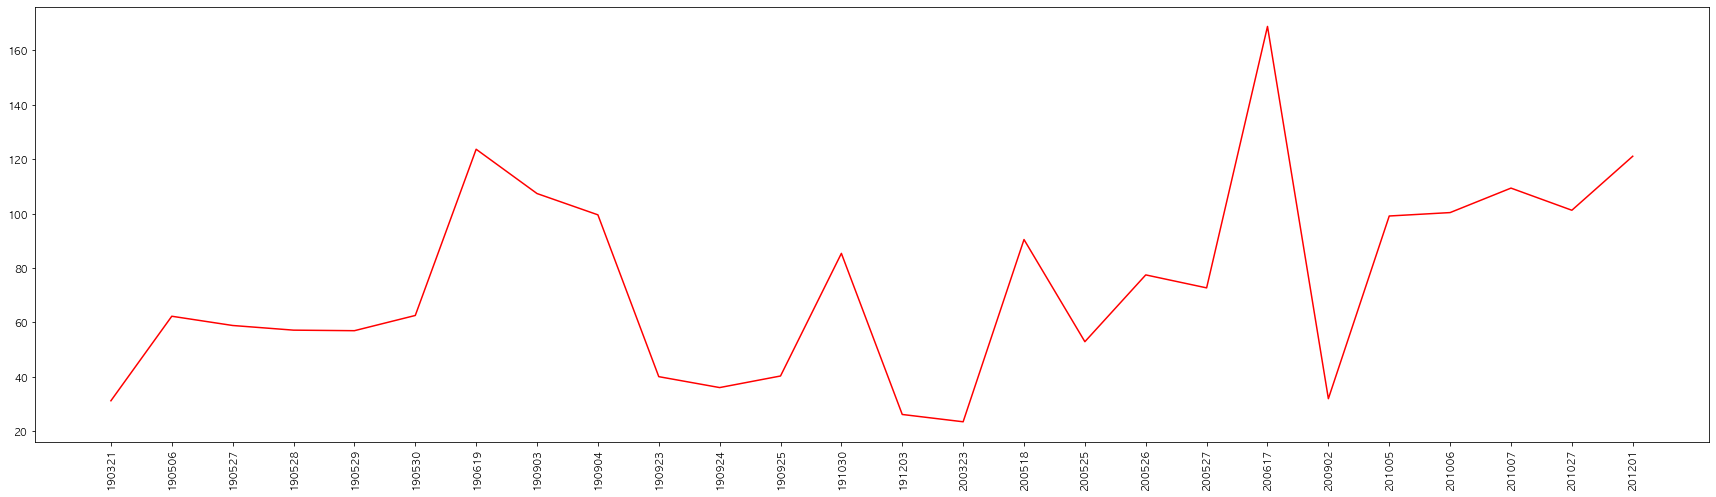

In [ ]:
# 선택한 선로에 한하여 패턴분석 시각화
lst_lane = ['광장-뚝도#1 T/L', '광장-뚝도#2 T/L']


for lane in lst_lane:
    print(lane)
    df_viz = df.loc[df['선로명'] == lane]
    
    fig,ax = plt.subplots(figsize=(30,8))

    ax1 = plt.plot(list(range(len(df_viz))), df_viz['부하전류'].values, color='red')
    ax.set_xticks(list(range(len(df_viz['측정일']))))
    ax.set_xticklabels(df_viz['측정일'].values, rotation=90)
    plt.show()

### 상관관계 분석

### 1. 상관관계 확인 - 전체 변수

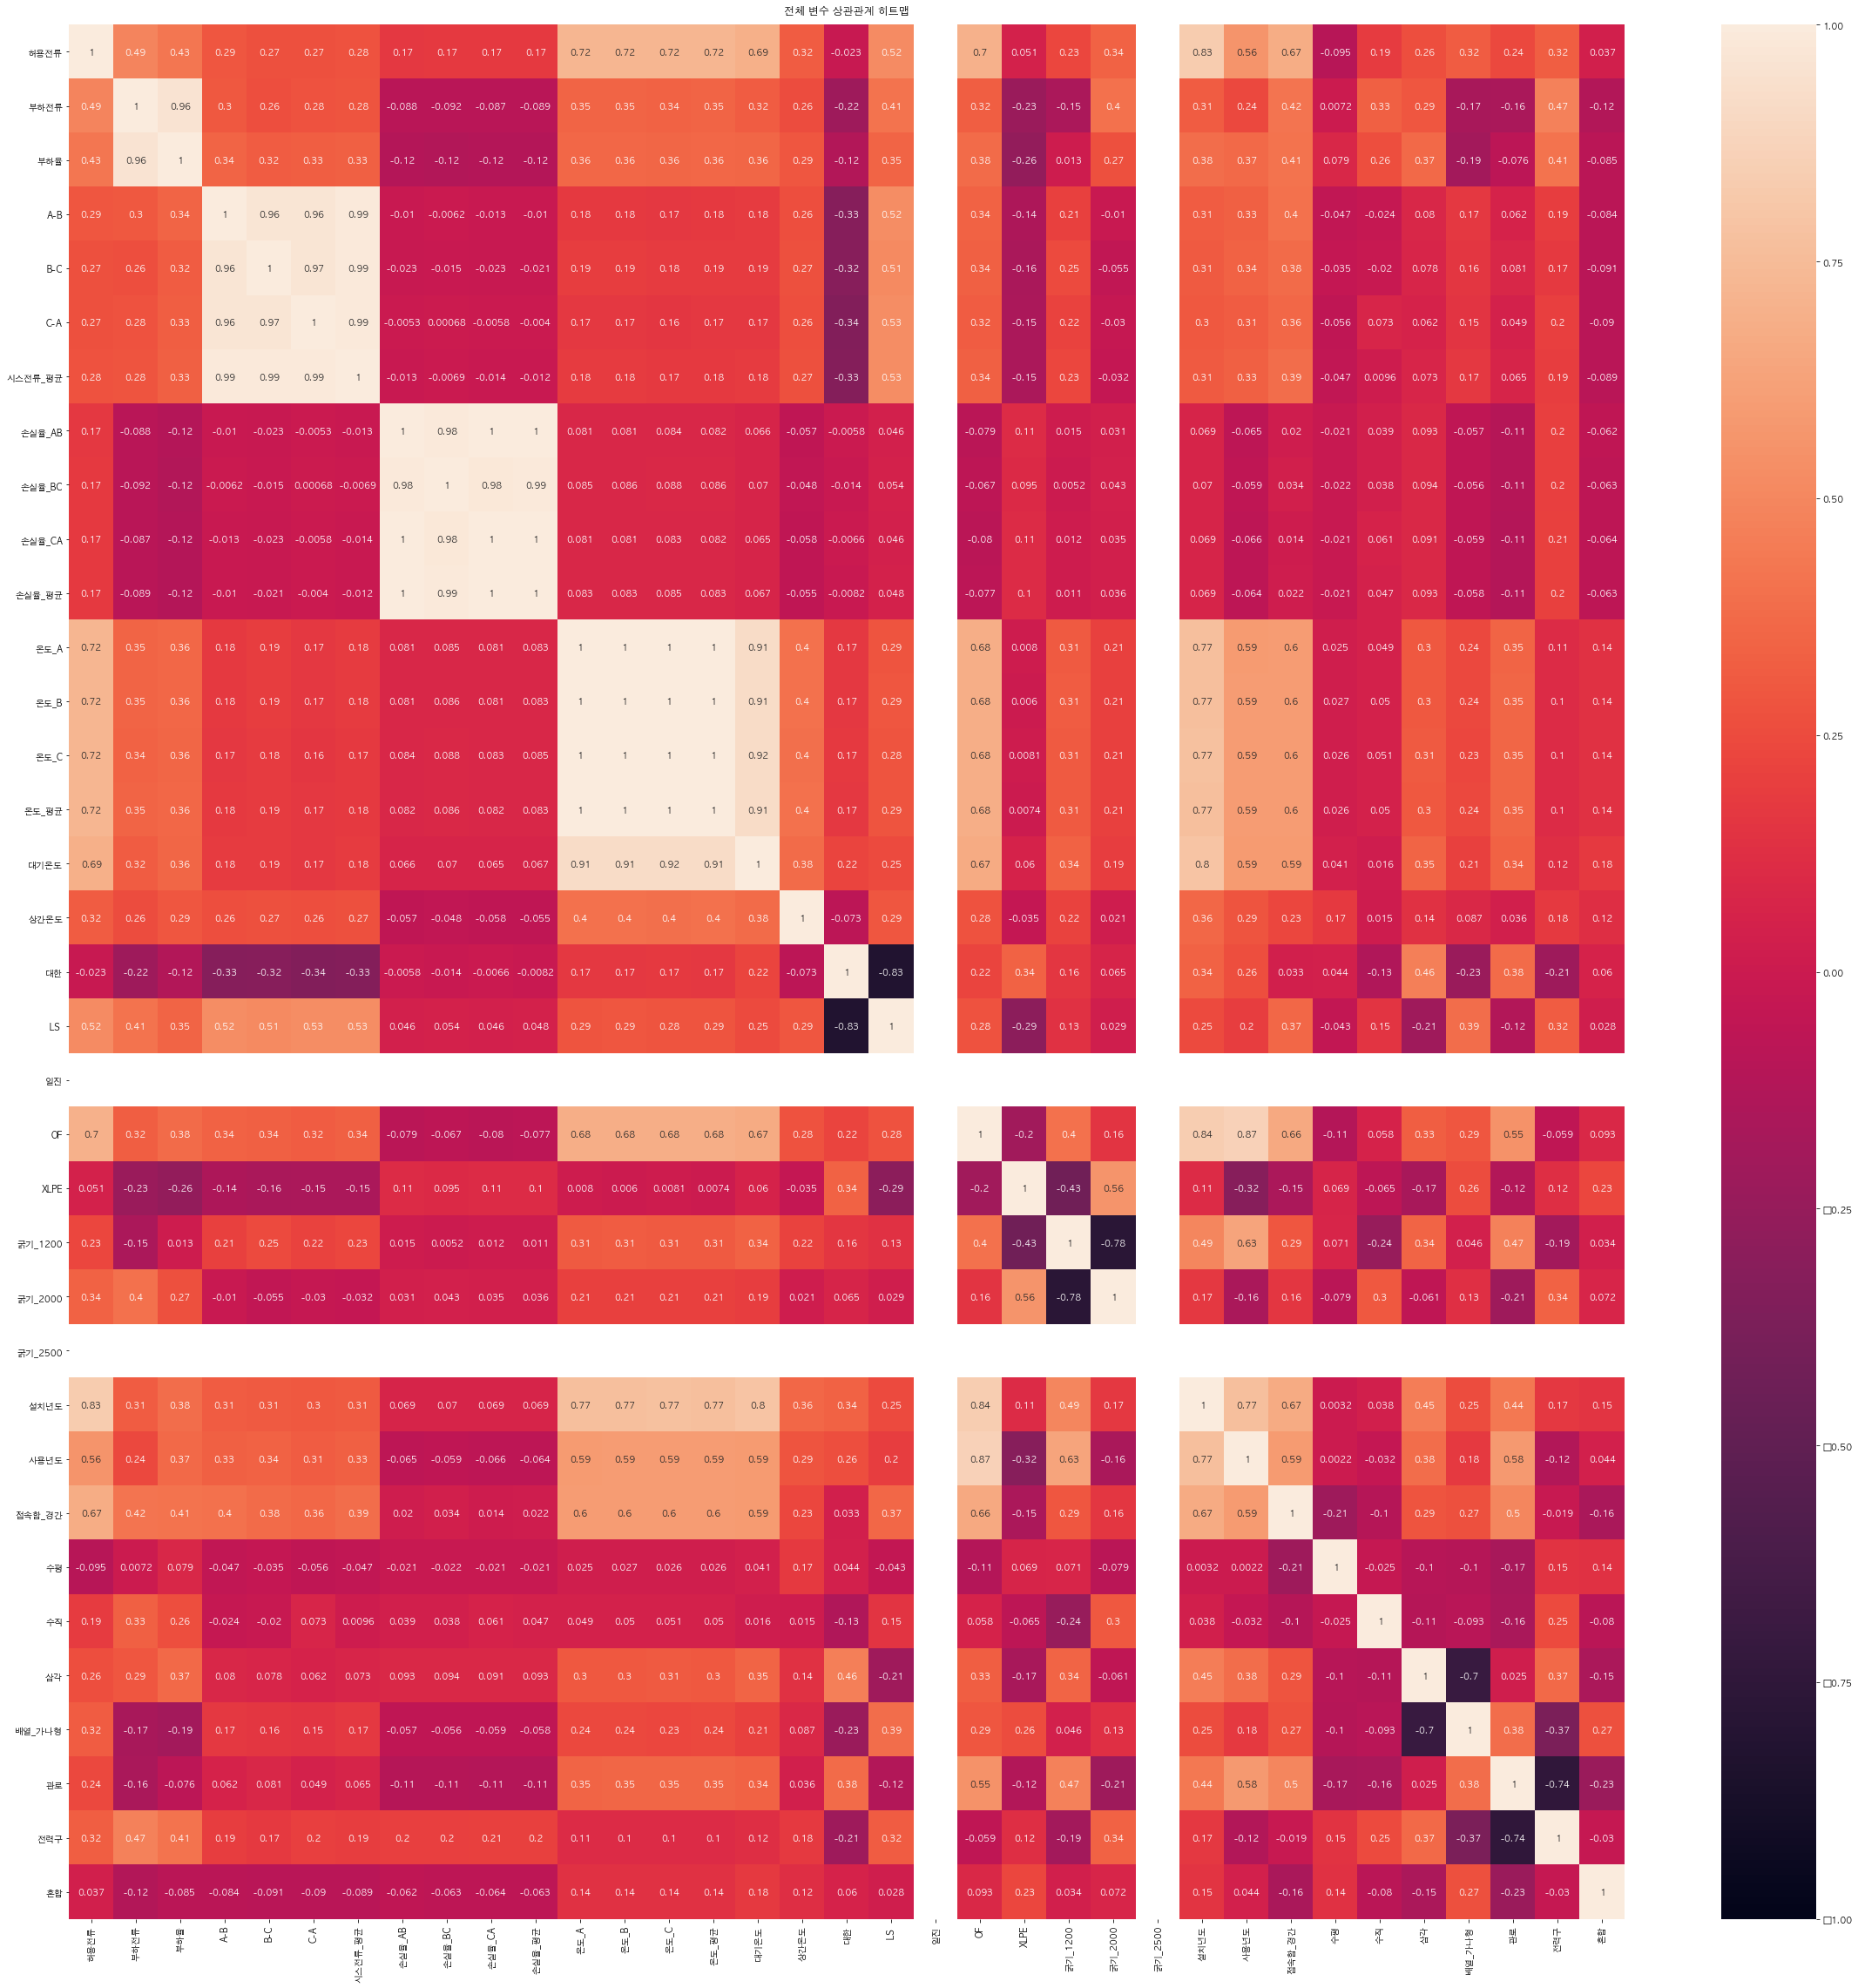

In [ ]:
plt.figure(figsize=(40,40))
sns.heatmap(df[num_cols].corr(), vmin=-1, vmax=1, annot=True)
plt.title('전체 변수 상관관계 히트맵', pad = 12)
plt.show()

### 1. 데이터 분포 확인 - 전체 변수

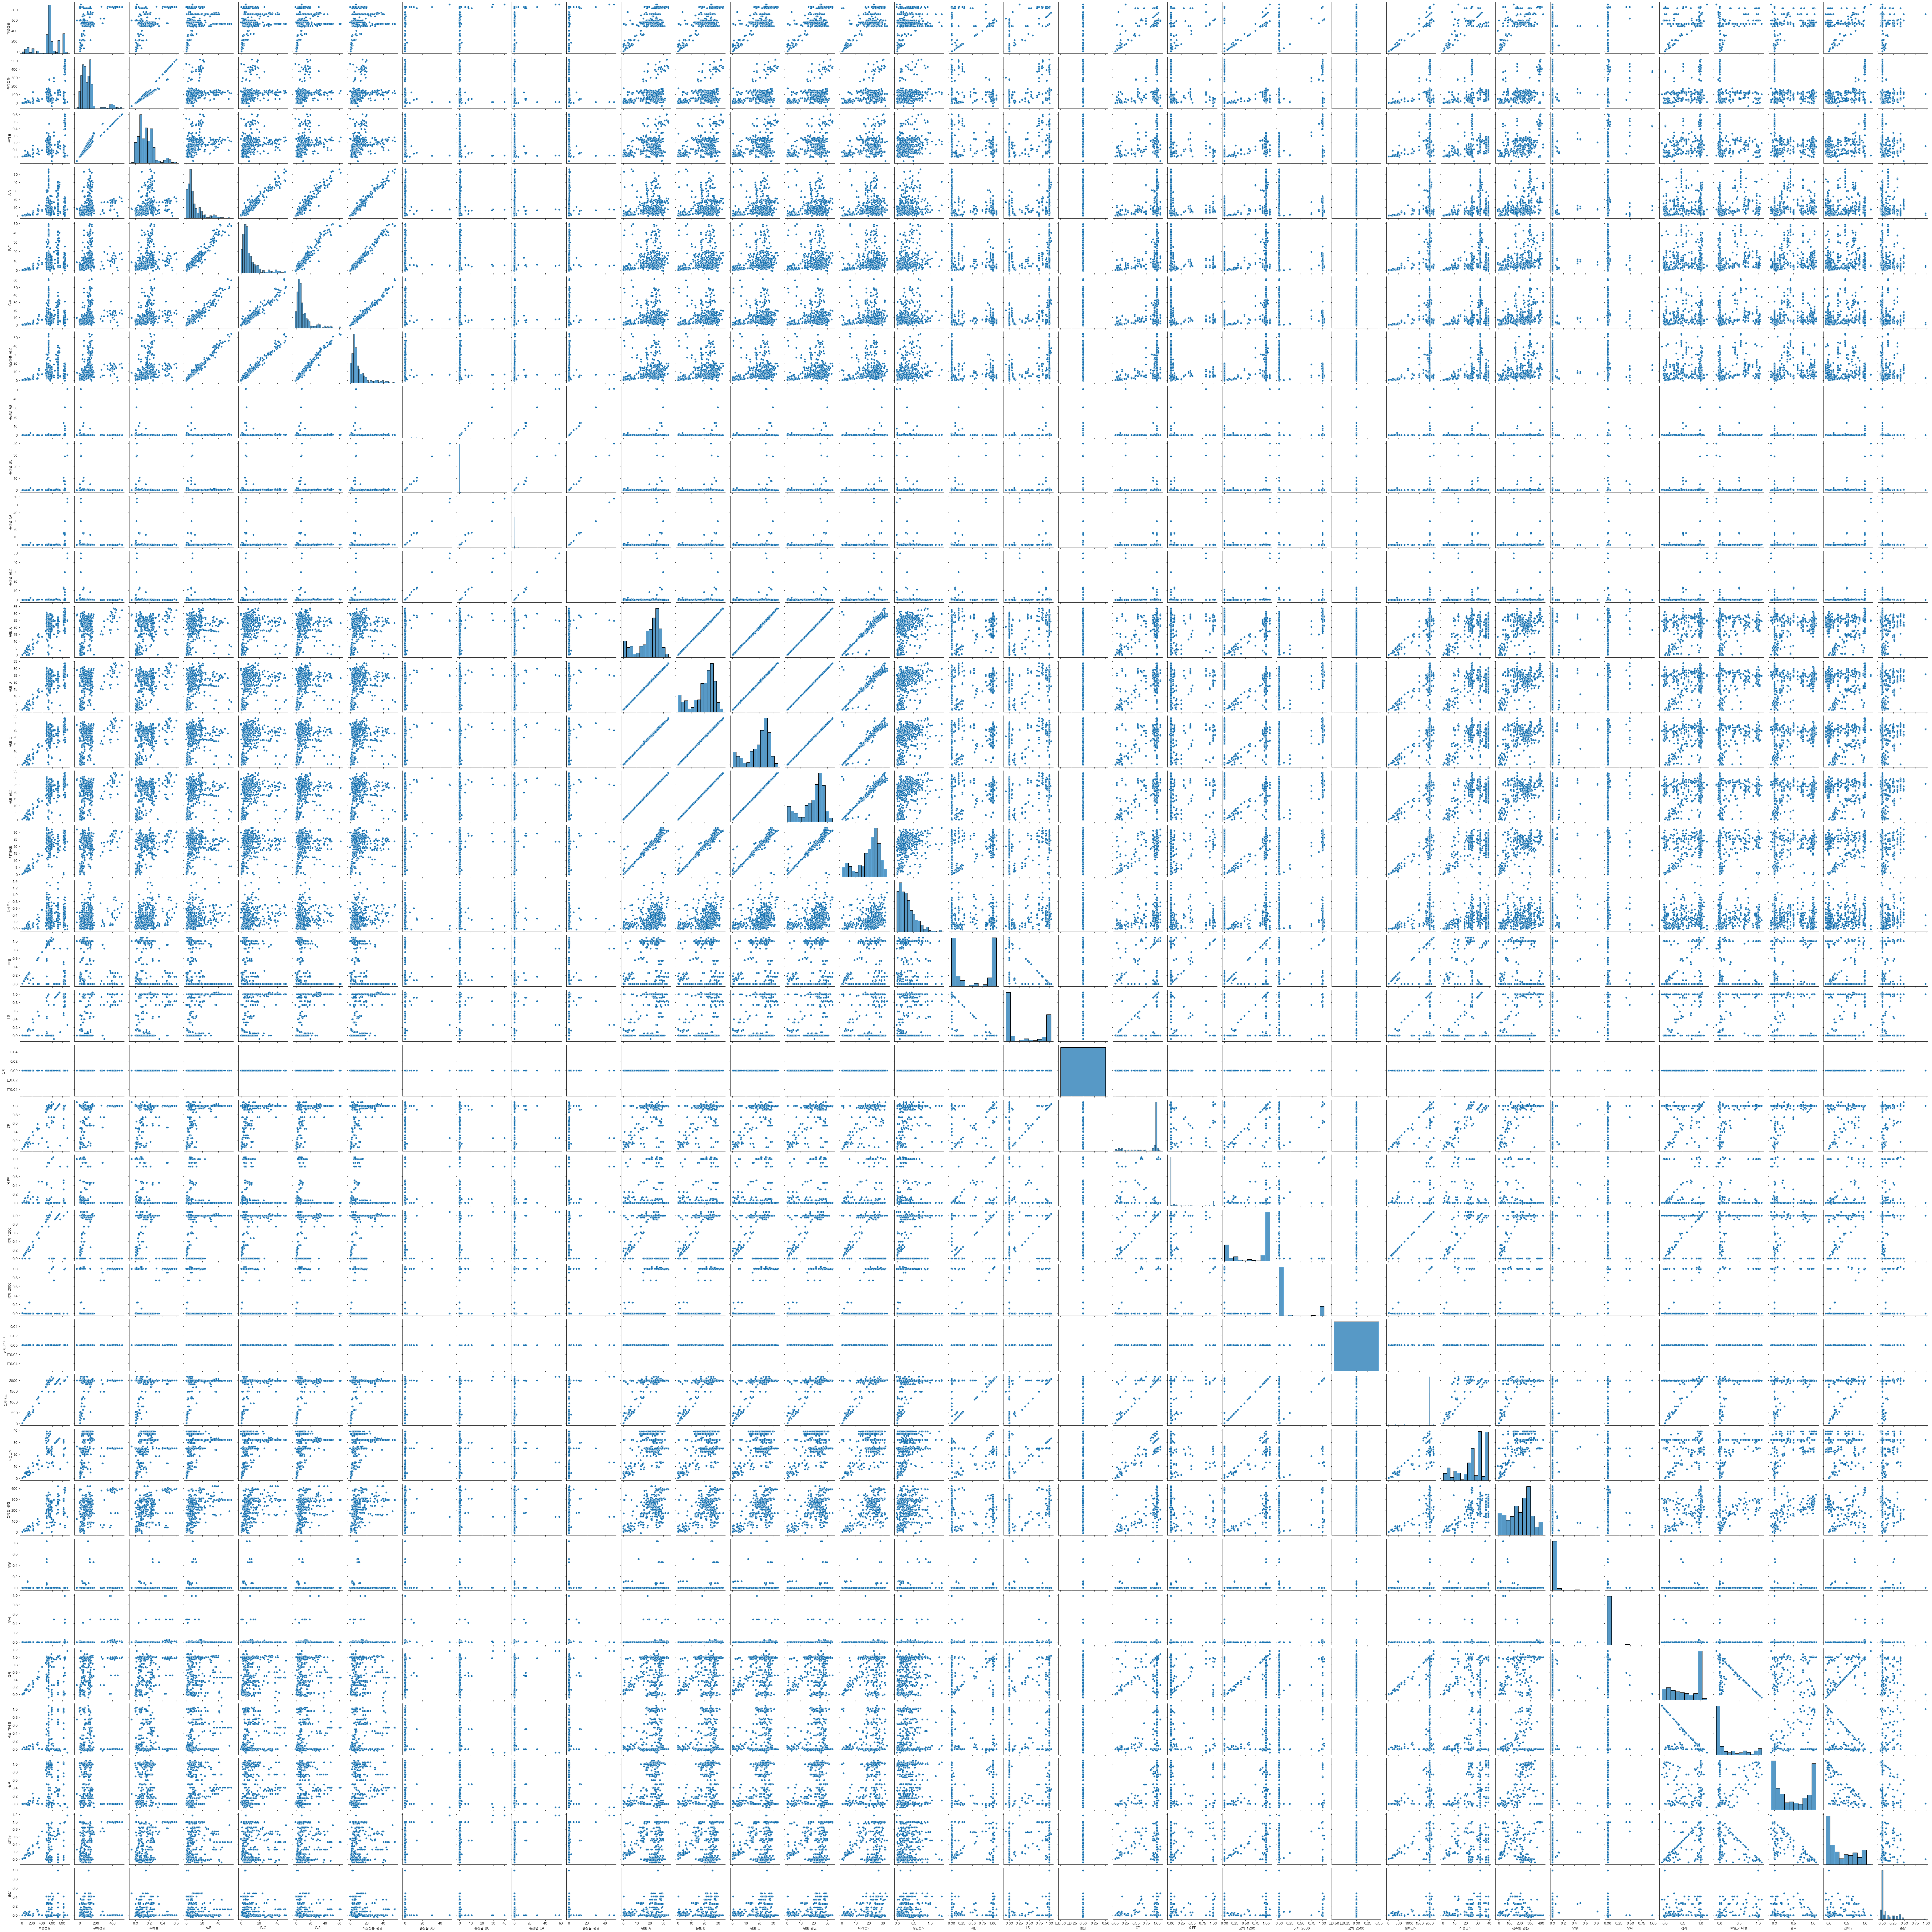

In [ ]:
sns.pairplot(df[num_cols])

### 2. 상관관계 확인 - 특정 선택한 변수

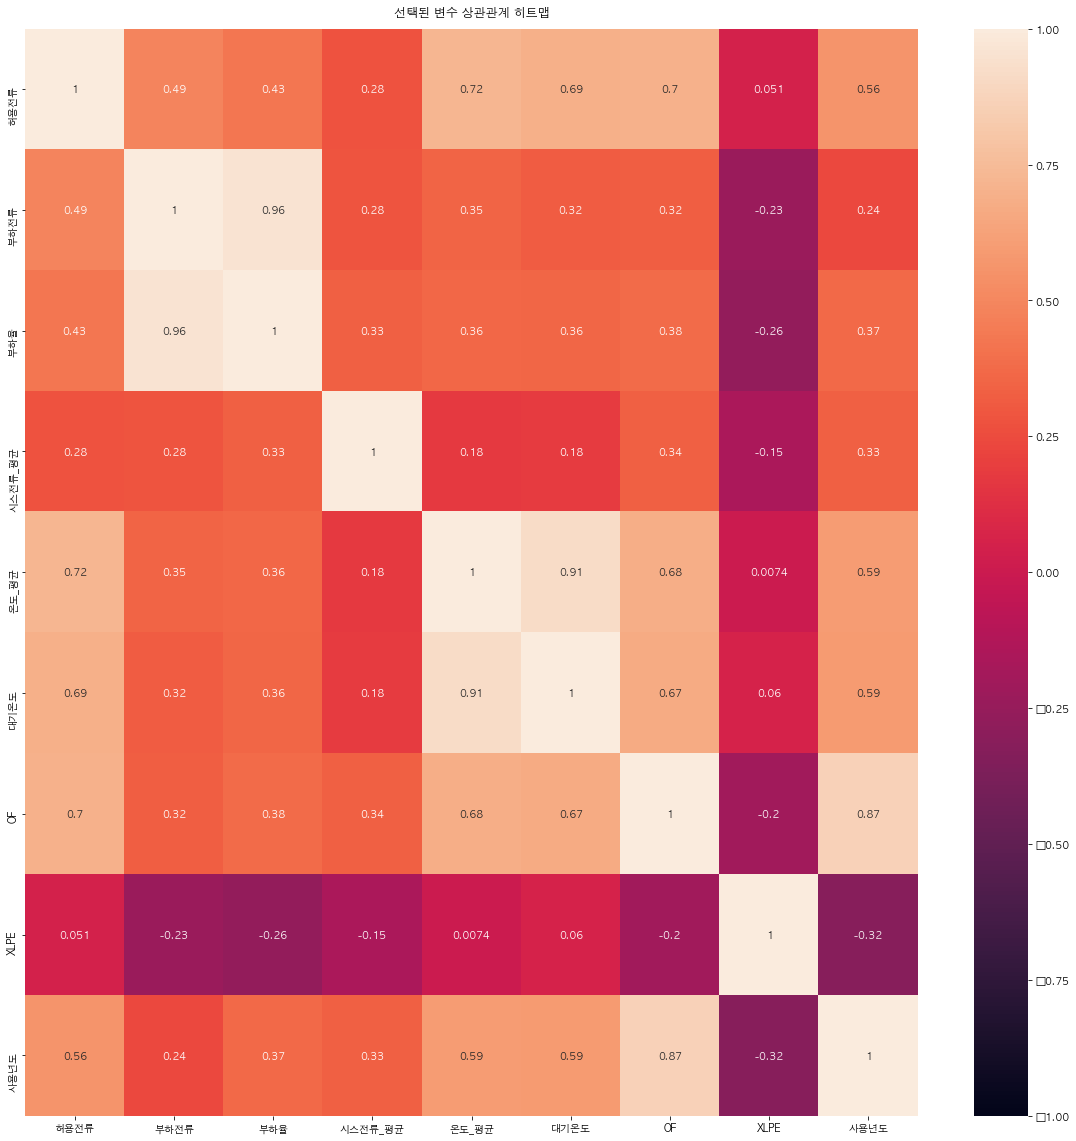

In [ ]:
plt.figure(figsize=(20,20))
selected_cols = ['허용전류','부하전류','부하율','시스전류_평균','온도_평균','대기온도','OF','XLPE','사용년도']
sns.heatmap(df[selected_cols].corr(), vmin=-1, vmax=1, annot=True)
plt.title('선택된 변수 상관관계 히트맵', pad = 12)
plt.show()

### 2. 데이터 분포 확인 - 특정 선택한 변수

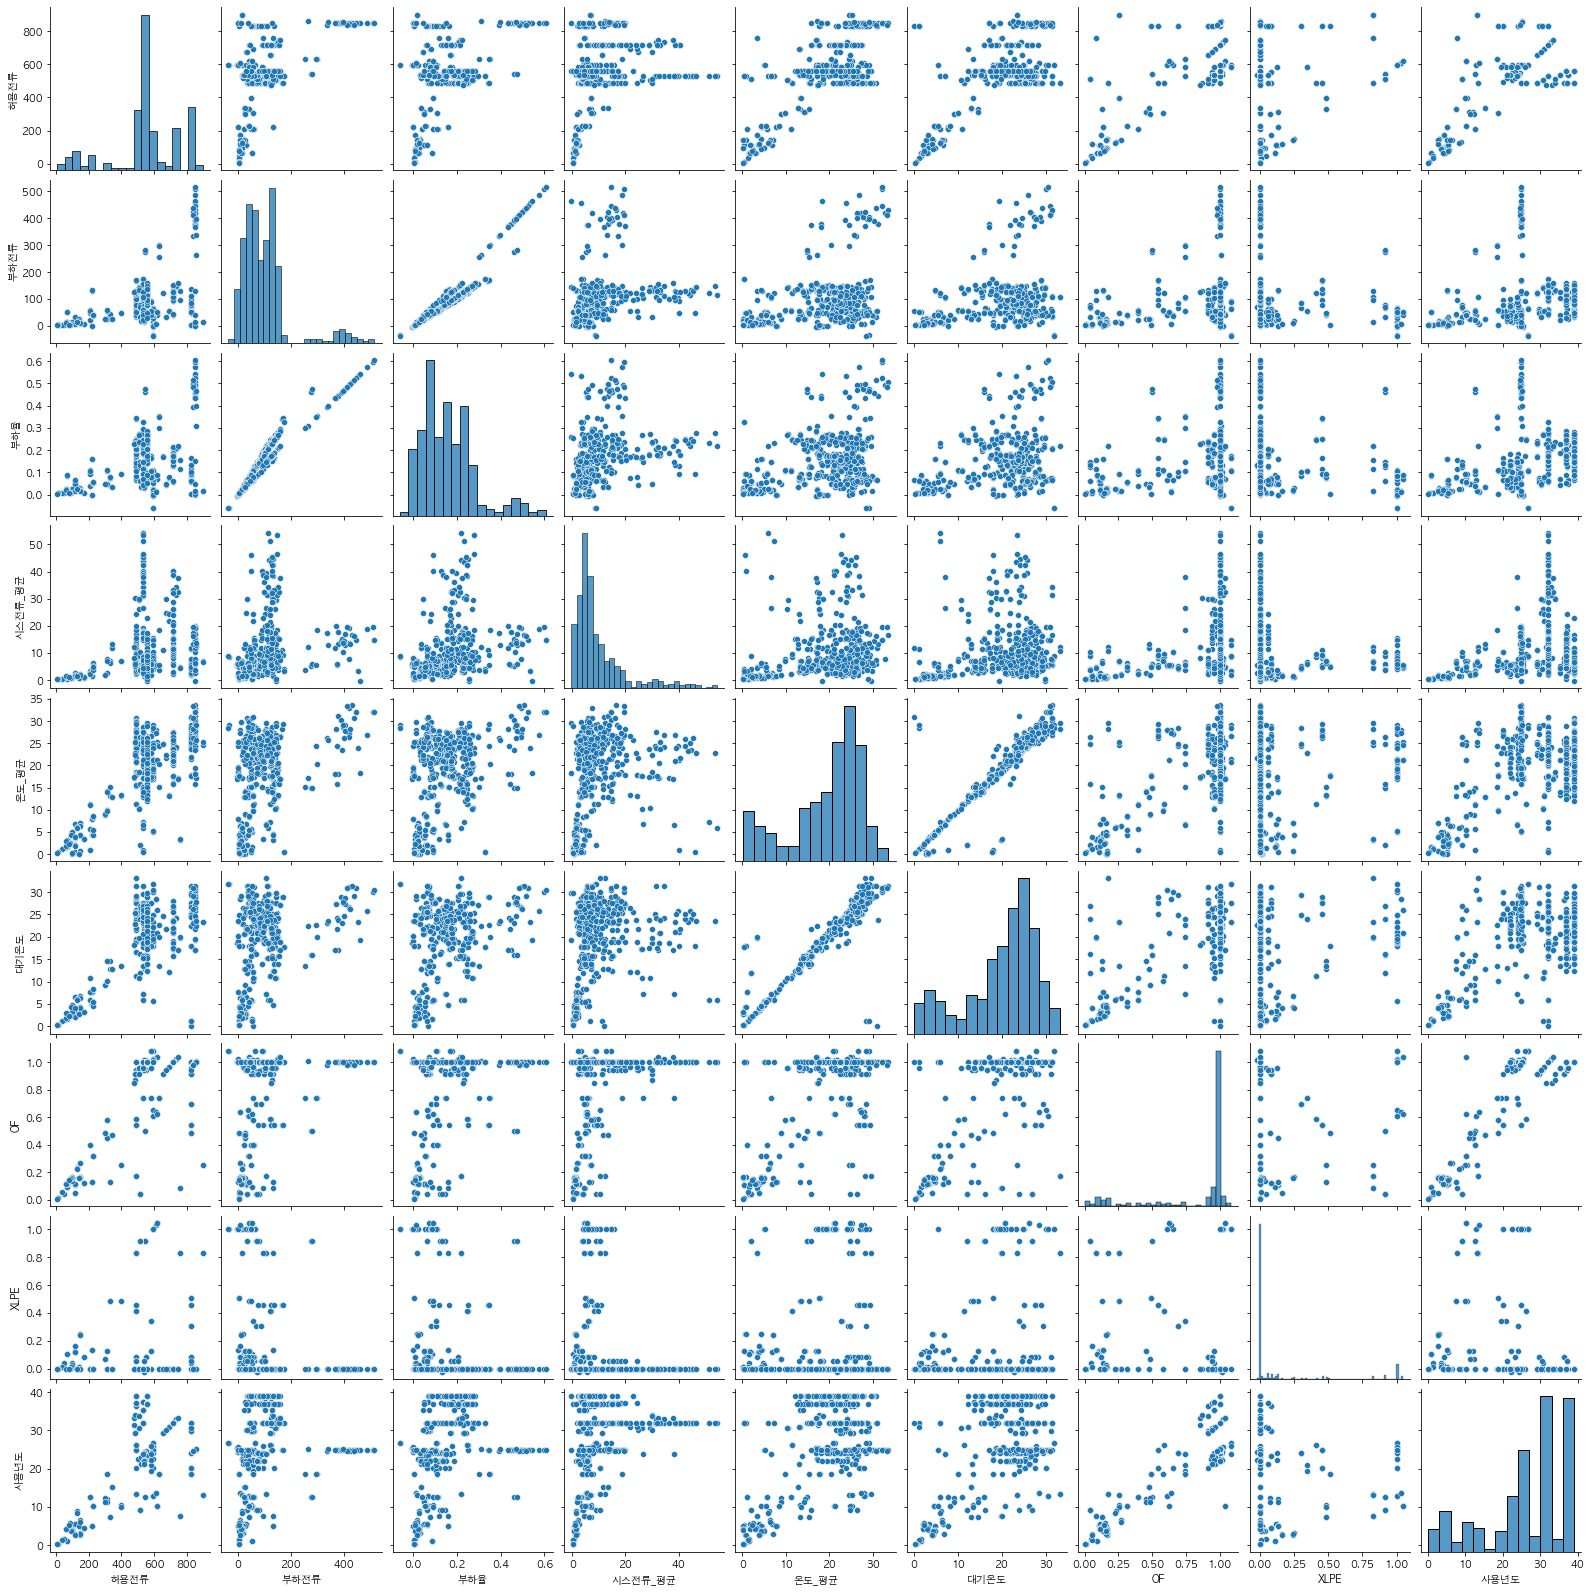

In [ ]:
sns.pairplot(df[selected_cols])

In [ ]:
df.head()

선로명     측정일        허용전류       부하전류       부하율        A-B        B-C  \
0  광장-뚝도#1 T/L  190321  116.529412  31.153782  0.063579   2.011261   2.021176   
1  광장-뚝도#1 T/L  190506  490.000000  61.228571  0.124956  15.197143  14.568571   
2  광장-뚝도#1 T/L  190527  490.000000  56.942857  0.116210   3.416190   7.248571   
3  광장-뚝도#1 T/L  190528  490.000000  56.000000  0.114286   4.900000   5.786667   
4  광장-뚝도#1 T/L  190529  490.000000  55.000000  0.112245   6.421429   6.110000   

         C-A    시스전류_평균    손실율_AB  ...       사용년도      접속함_경간        수평   수직  \
0   2.191008   2.074482  0.015353  ...   5.236975   16.830252  0.107563  0.0   
1  11.299048  13.688254  0.273157  ...  37.228571  309.104762  0.000000  0.0   
2   7.075238   5.913333  0.059875  ...  39.000000  315.057143  0.000000  0.0   
3   5.306667   5.331111  0.087572  ...  39.000000  287.780952  0.000000  0.0   
4   6.855714   6.462381  0.116856  ...  39.000000  307.542857  0.000000  0.0   

         삼각    배열_가나형        관로       전력구        혼합  yymm  
0  0.130252  0.000000  0.000000  0.178992  0.058824  1903  
1  0.361905  0.638095  0.942857 -0.028571  0.085714  1905  
2  1.028571 -0.028571  1.000000  0.000000  0.000000  1905  
3  1.000000  0.000000  1.000000  0.000000  0.000000  1905  
4  1.000000  0.000000  1.042857  0.000000 -0.042857  1905  

[5 rows x 38 columns]

# 3. 모델링 (-> 주 요인 분석 포함)

RandomForestRegressor 


Feature Importance of  RandomForestRegressor


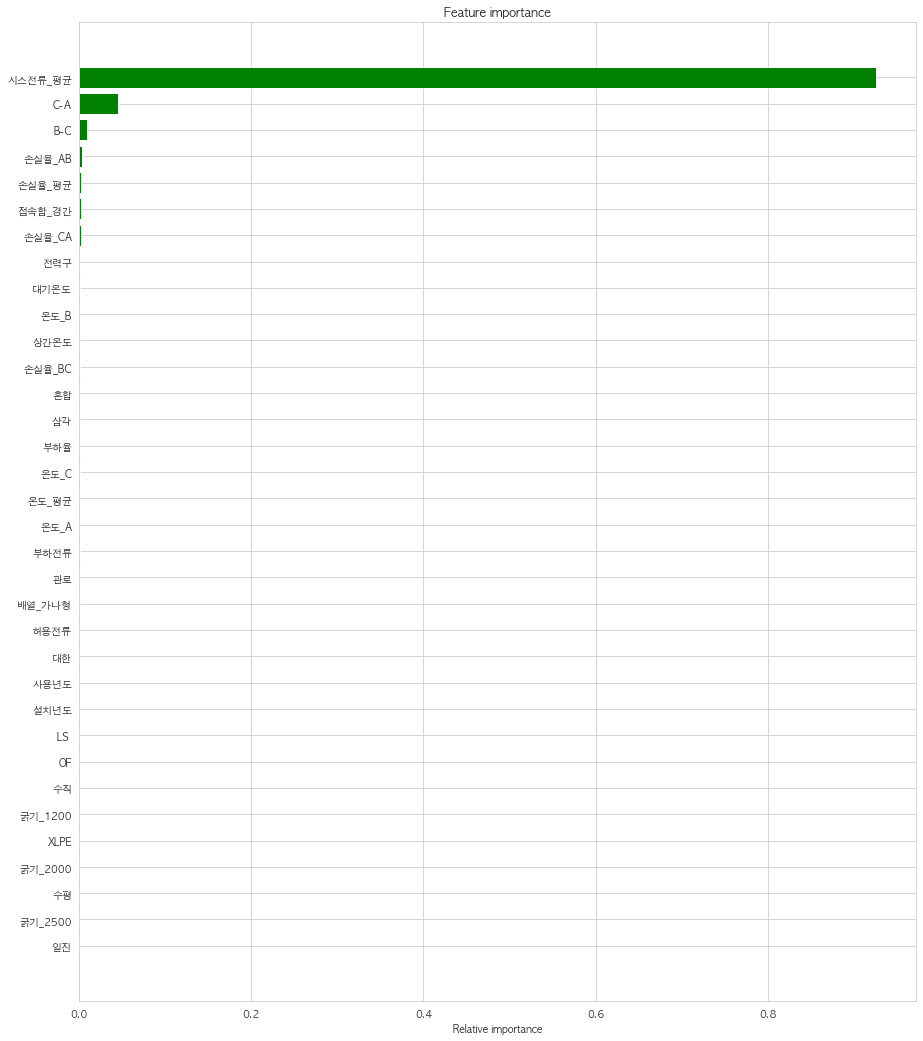

<Figure size 1440x576 with 0 Axes>

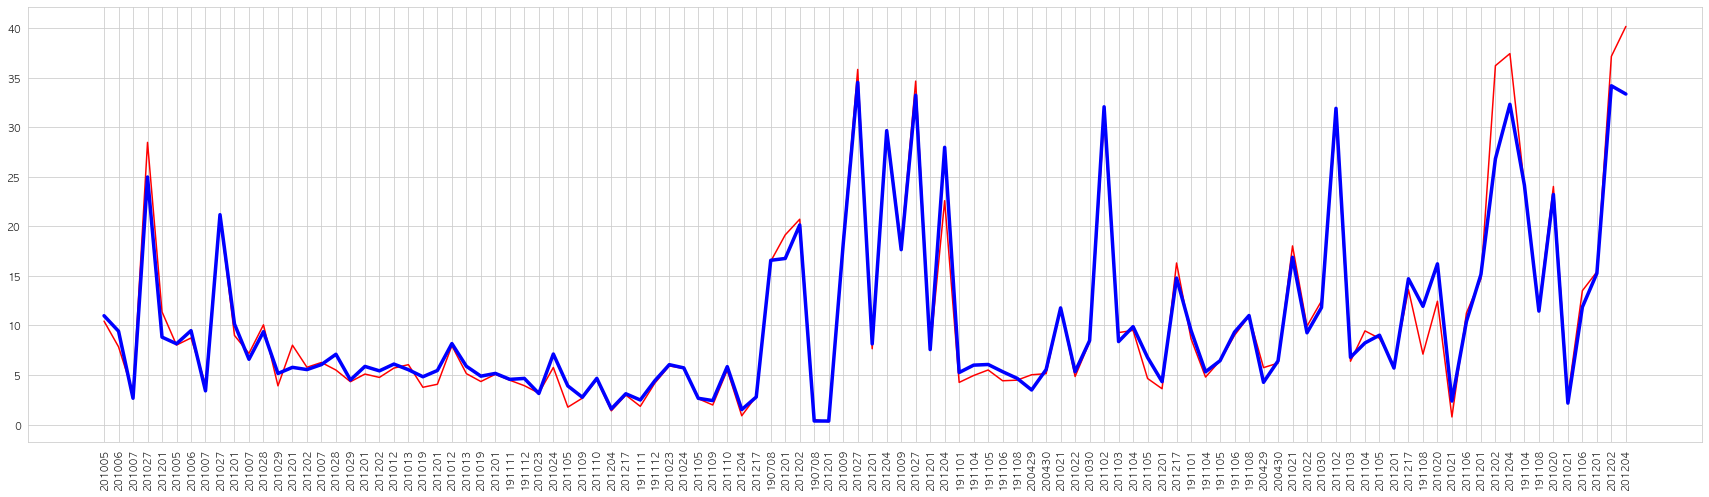

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
GradientBoostingRegressor 


Feature Importance of  GradientBoostingRegressor


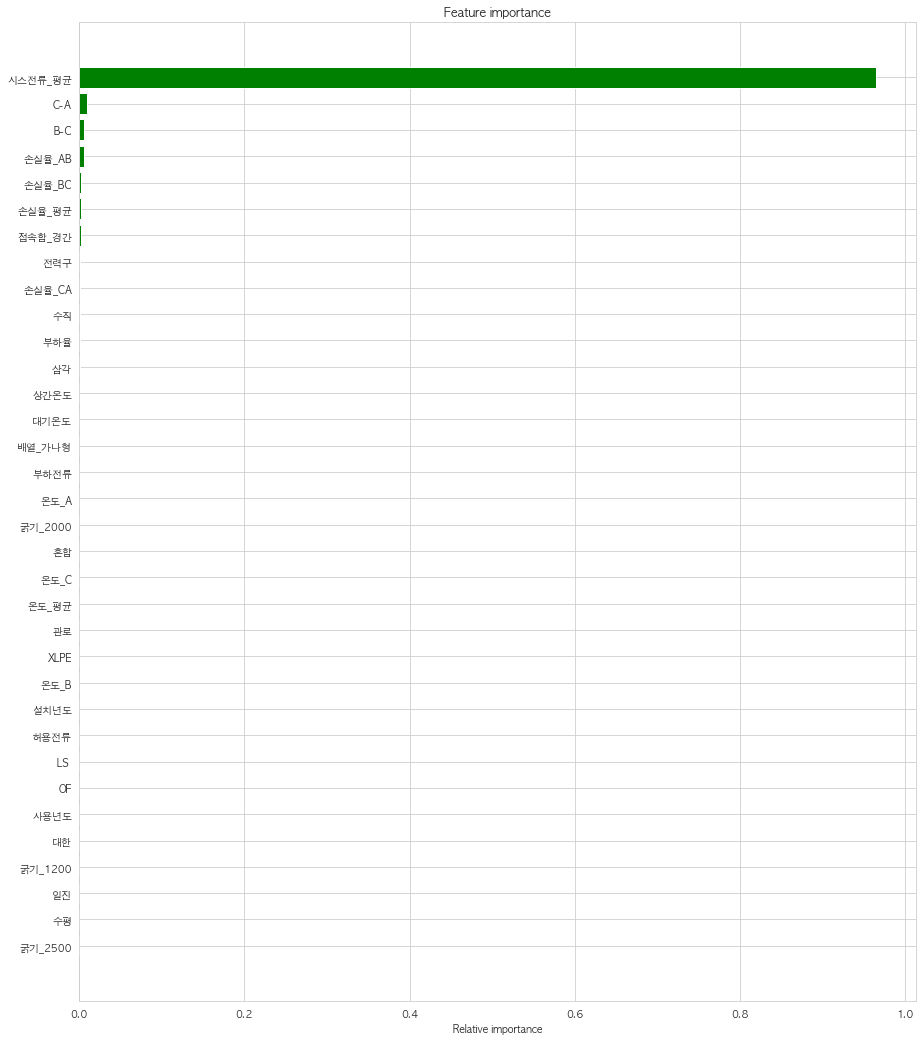

<Figure size 1440x576 with 0 Axes>

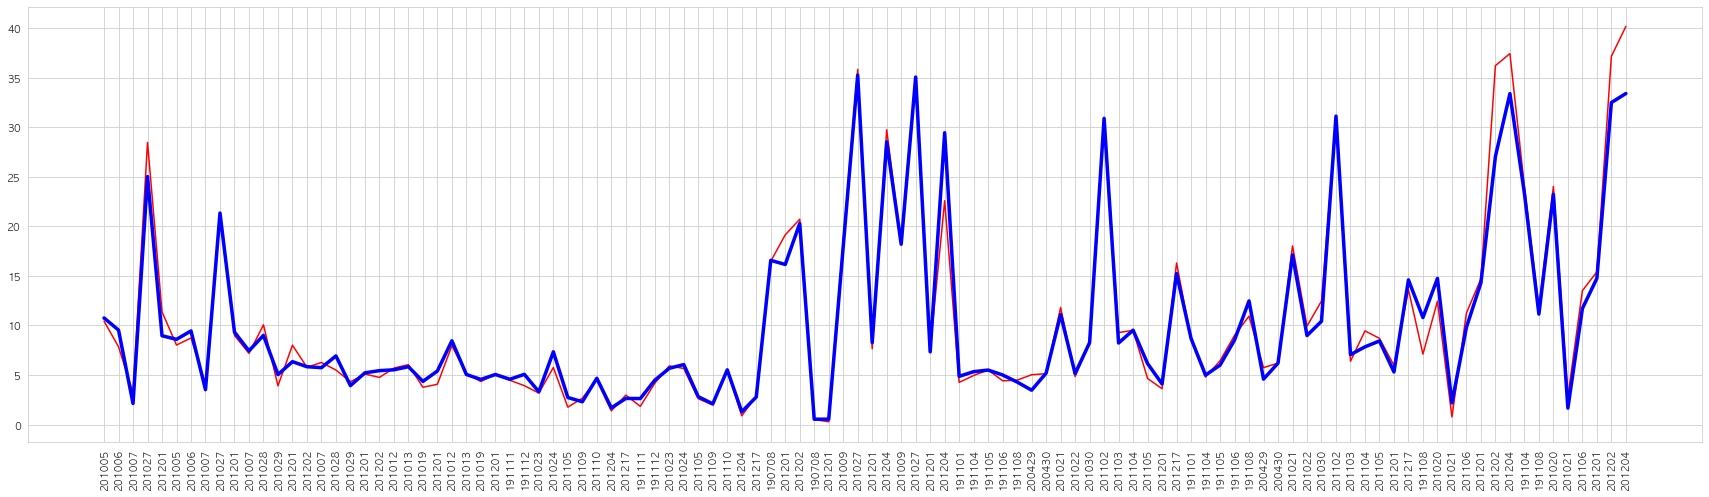

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
XGBRegressor 


[22:53:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Feature Importance of  XGBRegressor


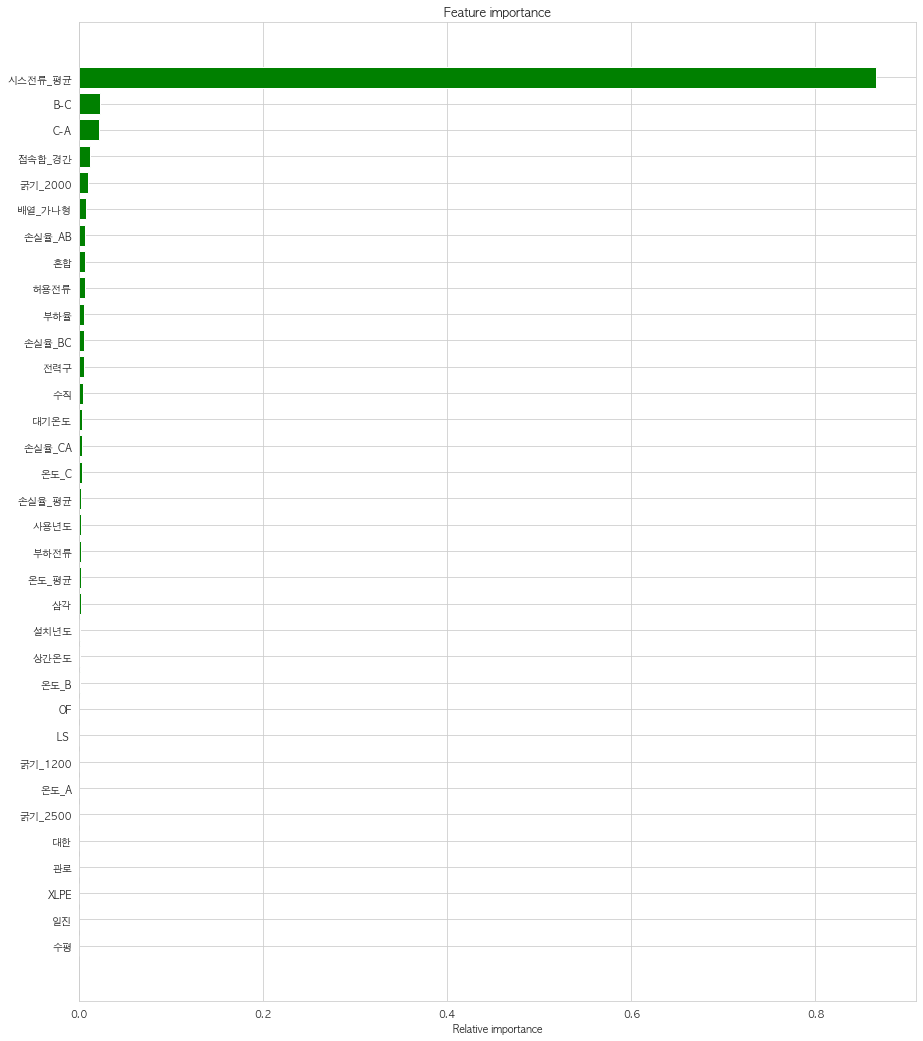

<Figure size 1440x576 with 0 Axes>

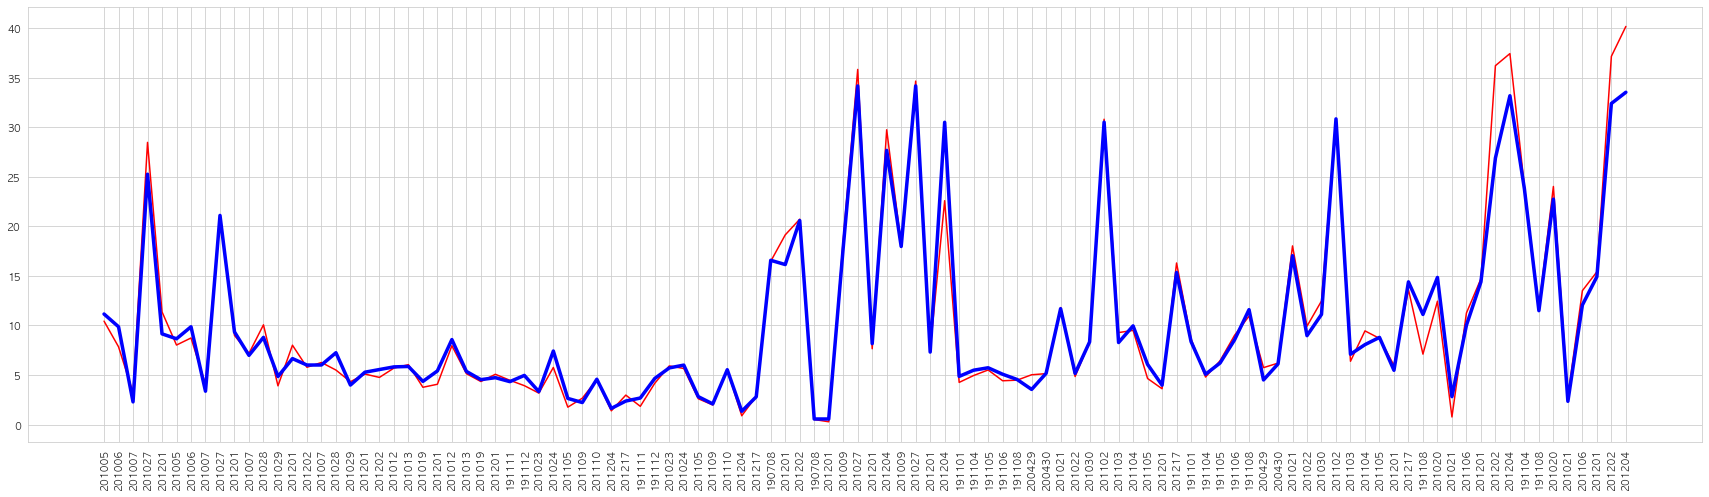

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [ ]:
# 성능 평가 및 과적합 검증
def MAE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)))
def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))
def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))
def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100

# 변수 중요도를 출력하기 위한 함수
def plot_feature_importance(model, df, figsize=(15, 18)):
    sns.set_style('whitegrid')
    
    feature_importance = model.feature_importances_
    feature_importance_rel = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    sorted_idx_rel = np.argsort(feature_importance_rel)
    ypos = np.arange(sorted_idx_rel.shape[0]) + .5
    
    n=0
    print("Feature Importance of ", model.__repr__().split('(')[0])
        
    plt.figure(figsize=figsize)
    plt.rcParams['font.family'] = 'AppleGothic'
    plt.barh(ypos, feature_importance[sorted_idx_rel], align='center', color = "Green")
    plt.yticks(ypos, df.columns[sorted_idx_rel])
    plt.xlabel('Relative importance')
    plt.title('Feature importance')
    plt.show()

# 실제값과 예측값 비교 시각화
def viz_result3(true, pred, lst_test_date):

    plt.figure(figsize=(20,8))
    fig,ax = plt.subplots(figsize=(30,8))

    ax1 = plt.plot(list(range(len(lst_test_date))), true, color='red')
    ax2 = plt.plot(list(range(len(lst_test_date))), pred, linewidth=3.5, dash_joinstyle='round', dash_capstyle='round', color='blue')

    ax.set_xticks(list(range(len(lst_test_date))))
    ax.set_xticklabels(lst_test_date, rotation=90)

    plt.show()   

# 모델 선택
model_rf = RandomForestRegressor()
model_gb = GradientBoostingRegressor()
model_xgb = XGBRegressor()

# 예측할 변수 선택
col_y = 'A-B'
col_x = list(set(num_cols)-set([col_y]))

model_list = [model_rf,model_gb, model_xgb] 

lst_total_result = []
lst_model_name = []
for model in model_list:
    model_name = type(model).__name__
    lst_model_name.append(model_name)
    print(model_name,'\n\n')

    train = df.loc[df['yymm'].isin(train_range)]
    test = df.loc[~df['yymm'].isin(train_range)]
    x_grid = test['측정일'].values
    X_train, y_train = train[col_x], train[col_y]
    X_test, y_test = test[col_x], test[col_y]

    model = model.fit(X_train, y_train)
    Y_test_pred = model.predict(X_test)

    Test_mae = MAE(y_test, Y_test_pred)
    Test_mse = MSE(y_test, Y_test_pred)
    Test_rmse = RMSE(y_test, Y_test_pred)
    Test_r2 = r2_score(y_test, Y_test_pred)

    lst_total_result.append([Test_mae, Test_mse, Test_rmse, Test_r2]) 
    
    plot_feature_importance(model, X_train)
    viz_result3(y_test, Y_test_pred, x_grid)
    
    print('-'*100)
    print('-'*100)

df_lst_fold_result = pd.DataFrame(lst_total_result, index = lst_model_name, columns=['mae','mse','rmse','r2'])

In [ ]:
df_lst_fold_result

mae       mse      rmse        r2
RandomForestRegressor      1.021184  3.088798  1.757498  0.964487
GradientBoostingRegressor  0.983870  3.014813  1.736322  0.965338
XGBRegressor               0.999143  3.219153  1.794200  0.962988

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation

def load_data(data_all, look_back, lst_cols_x, cols_y):

    scaler_x_tr = MinMaxScaler()
    scaler_x_te = MinMaxScaler()
    scaler_y_tr = MinMaxScaler()
    scaler_y_te = MinMaxScaler()
    data_all = data_all[lst_cols_x+[cols_y]]

    data_all[lst_cols_x] = scaler_x_tr.fit_transform(data_all[lst_cols_x].values)
    data_all[cols_y] = scaler_y_tr.fit_transform(data_all[cols_y].values.reshape(-1,1))
       
    data_all = data_all.astype(np.float32)
    
    return data_all

def create_dataset(dataset, look_back):

    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        data_x.append(a)
        data_y.append(dataset[i + look_back, -1])
    return np.array(data_x), np.array(data_y)

lst_fold_result = []

col_y = 'A-B'
col_x = list(set(num_cols)-set([col_y]))

train = df.loc[df['yymm'].isin(train_range)]
test = df.loc[~df['yymm'].isin(train_range)]

train = load_data(train, 3, col_x, col_y)
test = load_data(test, 3, col_x, col_y)

# 데이터 구성 변환
train_x, train_y = create_dataset(train.values, 3)
test_x, test_y = create_dataset(test.values, 3)

train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], -1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], -1))    

# lstm 모델 학습 
model = Sequential()
model.add(LSTM(48))
model.add(Dense(1))
model.compile(loss='mean_squared_error', metrics=['acc'], optimizer='adam')
history = model.fit(x=train_x, 
                y=train_y,
                validation_split=0.2,
                epochs=10,
                verbose=1,
                shuffle=False
                )

# 모델 예측
Y_test_pred = model.predict(test_x)
Y_test_pred = [i[0] for i in Y_test_pred]

# 모델 성능 평가
Test_mae = MAE(test_y, Y_test_pred)
Test_mse = MSE(test_y, Y_test_pred)
Test_rmse = RMSE(test_y, Y_test_pred)
Test_r2 = r2_score(test_y, Y_test_pred)

# 결과 저장
lst_fold_result.append([Test_mae, Test_mse, Test_rmse, Test_r2])
df_lst_fold_result_lstm = pd.DataFrame(lst_fold_result, index=['lstm'], columns=['mae','mse','rmse','r2'])

Epoch 1/10
9/9 [==============================] - 0s 42ms/step - loss: 0.0358 - acc: 0.0036 - val_loss: 0.0411 - val_acc: 0.0000e+00
Epoch 2/10
9/9 [==============================] - 0s 5ms/step - loss: 0.0344 - acc: 0.0036 - val_loss: 0.0426 - val_acc: 0.0000e+00
Epoch 3/10
9/9 [==============================] - 0s 5ms/step - loss: 0.0287 - acc: 0.0036 - val_loss: 0.0351 - val_acc: 0.0000e+00
Epoch 4/10
9/9 [==============================] - 0s 5ms/step - loss: 0.0287 - acc: 0.0036 - val_loss: 0.0362 - val_acc: 0.0000e+00
Epoch 5/10
9/9 [==============================] - 0s 5ms/step - loss: 0.0276 - acc: 0.0036 - val_loss: 0.0350 - val_acc: 0.0000e+00
Epoch 6/10
9/9 [==============================] - 0s 5ms/step - loss: 0.0271 - acc: 0.0036 - val_loss: 0.0354 - val_acc: 0.0000e+00
Epoch 7/10
9/9 [==============================] - 0s 5ms/step - loss: 0.0264 - acc: 0.0036 - val_loss: 0.0349 - val_acc: 0.0000e+00
Epoch 8/10
9/9 [==============================] - 0s 5ms/step - loss: 0.025

<Figure size 1440x576 with 0 Axes>

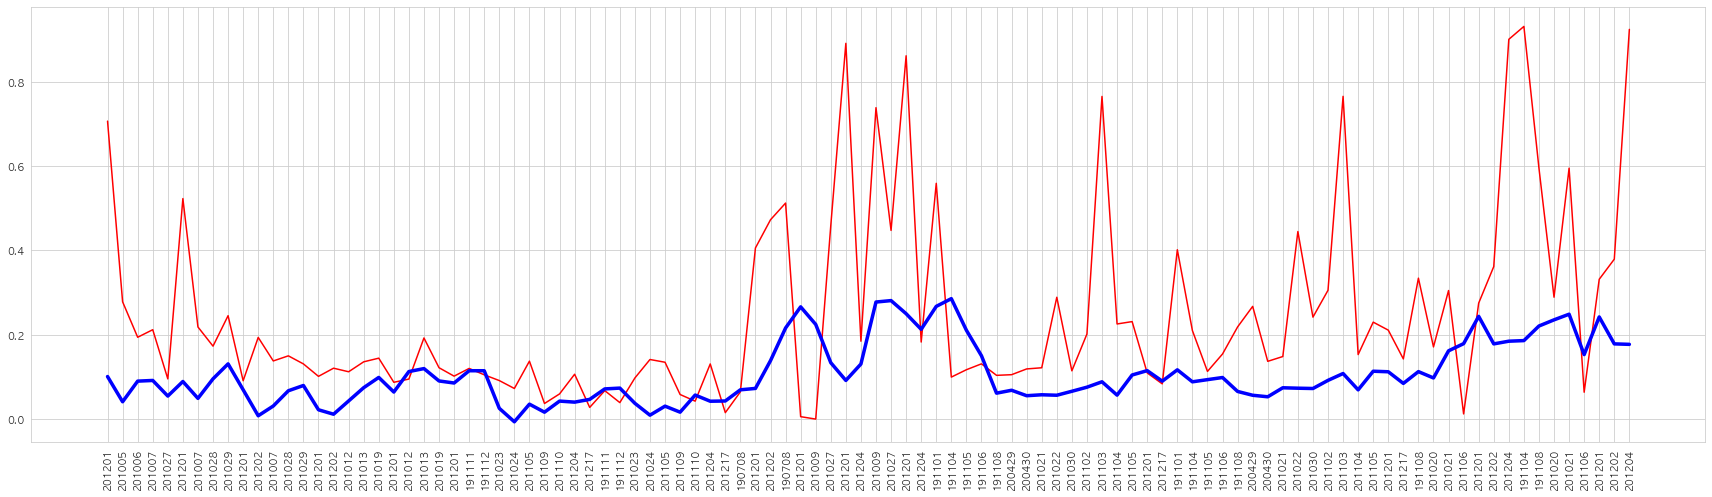

In [ ]:
viz_result3(test_y, Y_test_pred, x_grid[4:])

In [ ]:
df_total = pd.concat([df_lst_fold_result,df_lst_fold_result_lstm], axis=0)
df_total

mae       mse      rmse        r2
RandomForestRegressor      1.021184  3.088798  1.757498  0.964487
GradientBoostingRegressor  0.983870  3.014813  1.736322  0.965338
XGBRegressor               0.999143  3.219153  1.794200  0.962988
lstm                       0.164848  0.061733  0.248462 -0.210440